## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-02 21:38:57--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2021-10-02 21:38:57 (5.48 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [9]:
df.dtypes, df.dtypes.index

(seniority     int64
 home         object
 time          int64
 age           int64
 marital      object
 records      object
 job          object
 expenses      int64
 income        int64
 assets        int64
 debt          int64
 amount        int64
 price         int64
 default       int64
 dtype: object,
 Index(['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
        'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'],
       dtype='object'))

In [10]:
numerical = ['seniority', 'time', 'age', 'expenses', 
             'income', 'assets', 'debt', 'amount', 
             'price']
categorical = ['home', 'marital', 'records', 'job']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [13]:
from sklearn.metrics import roc_auc_score 

In [14]:
for n in numerical:
    score = roc_auc_score(y_train, df_train[n])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[n])
    print('%s=%.3f' % (n, score))

seniority=0.709
time=0.561
age=0.573
expenses=0.501
income=0.682
assets=0.649
debt=0.505
amount=0.591
price=0.504


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

__Answer Q1: seniority=0.709__

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']



In [16]:
def train(df_t, y_t, C=1.0):
    dicts = df_t[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear',C=C,max_iter=1000)
    model.fit(X_train, y_t)
    
    return dv, model

In [17]:
dv, model = train(df_train, y_train)

In [18]:
dv.get_feature_names()

['assets',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'records=no',
 'records=yes',
 'seniority']

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [19]:
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.811

__Answer Q2: roc_auc_score~0.812__

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [20]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, fp, fn, tn))

In [21]:
auc_columns = ['threshold','tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=auc_columns)

df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [22]:
df_scores.isnull().sum()

threshold    0
tp           0
fp           0
fn           0
tn           0
fpr          0
tpr          0
p            7
r            0
dtype: int64

In [23]:
df_scores['p'] = df_scores['p'].fillna(0)

In [24]:
df_scores[::10]

,threshold,tp,fp,fn,tn,fpr,tpr,p,r
0,0.0,246,645,0,0,1.000000,1.000000,0.276094,1.000000
10,0.1,235,445,11,200,0.689922,0.955285,0.345588,0.955285
20,0.2,216,278,30,367,0.431008,0.878049,0.437247,0.878049
30,0.3,187,172,59,473,0.266667,0.760163,0.520891,0.760163
40,0.4,148,108,98,537,0.167442,0.601626,0.578125,0.601626
50,0.5,112,64,134,581,0.099225,0.455285,0.636364,0.455285
60,0.6,78,38,168,607,0.058915,0.317073,0.672414,0.317073
70,0.7,43,15,203,630,0.023256,0.174797,0.741379,0.174797
80,0.8,22,6,224,639,0.009302,0.089431,0.785714,0.089431
90,0.9,6,2,240,643,0.003101,0.024390,0.750000,0.024390


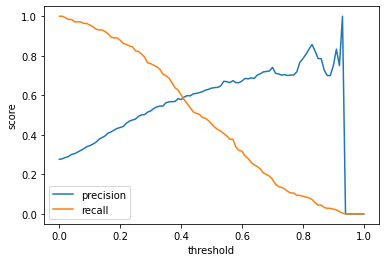

In [25]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

__Answer Q3: thershold~0.4__

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [26]:
df_scores['F1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

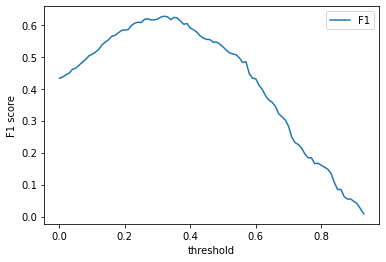

In [27]:
plt.plot(df_scores.threshold, df_scores.F1, label='F1')
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

__Answer Q4: F1~0.3__

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [28]:
from sklearn.model_selection import KFold

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [31]:
def predict(df,dv,model):
    dicts = df[columns].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [32]:
scores = []
C = 1.0

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val,dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

__Answer Q5: STD~0.014__

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [34]:
from tqdm.auto import tqdm

In [36]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):

    scores = []

    kfold = KFold(n_splits=n_splits,shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val,dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.812 +- 0.014


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

__Answer Q6: C=1__

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.